# Binary Edge Switcher
#### Greedy strategy for finding the single most advantageous edge reversal for computing a given query $p(X|Y_{0},Y_{1},...,Y_{n})$ over a DAG $G$. 
- Finds the set of nodes required to compute a query, $\Delta(G,q)$,
- Finds the set of covered edges,
- Finds the covered edge which, if switched, reduces $\Delta(G,q)$ most,
- Reverses the edge and calculates updated probability tables.

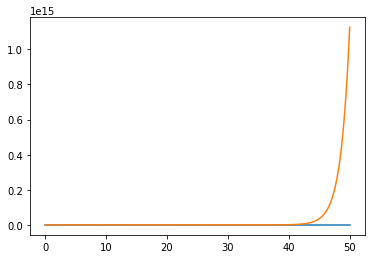

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from numpy import *
import math
import matplotlib.pyplot as plt


def f1(x):
    return(x**5)
def f2(x):
    return(2**x)

t = linspace(0,50,1000)

plt.plot(t, f1(t), t, f2(t))
plt.show()

### Query cost
This first section of code determines the number of vertices necessary to calculate a given query, finds the set of covered edges, and returns the most advantageous reversal for a given query (measured by number ot vertices reduced in the calculation). All computations are done over a DAG $G$ with respect to a specific query $p(X|Y_{0}, Y_{1},...Y_{n})$.
- is_ancestor: checks whether one node is an ancestor of another.
- check_paths: iterates through paths to determine whether two sections of the graph are disjoint given a condition.
- find_case: determines whether a query is in the special case or general case while calculating query.
- find_covered_edges: find the set of covered edges in a graph
- is_advantageous: determines whether a reversal reduces the number of nodes needed to compute the query, returns how many the computation is reversed by. 
- best_reversal: returns the maximally advantageous reversal to reduce nodes needed in query computation. 

In [2]:
## Helper function for find_case()
def is_ancestor(G,X,Y): #checks whether X is an ancestor of Y
    if X in nx.ancestors(G,Y):
        return(1)

In [3]:
## Helper function for find_case()
## checks for paths between targets and parents of conditions.
def check_paths(G,X,Y,cases):
    skeleton = G.to_undirected()
    y_ancestors = list(nx.ancestors(G,Y))
    paths = list(nx.all_simple_paths(skeleton, X, Y, cutoff=None)) #use skeleton so they are undirected (routes not paths).

    if len(y_ancestors) == 0:
        cases[Y] = "special" #Yj in TRIVIAL SPECIAL CASE
        return(cases)

    # The logic of the following is to find paths from X to Y: if any of them pass through an ancestor of Y
    # then there is a "back route" to Y through its ancestors, meaning there is a path connecting X to a(Y)
    # which does not pass through Y. 
    for path in paths:
        for y_ancestor in y_ancestors:
            if y_ancestor in path: #There exists a path from X to a(Y) which does not pass through Y
                cases[Y] = "general" #Yj IN GENERAL CASE
                return(cases)
            else:
                continue
            
    #Only reaches this block of code if all paths to a(Y) passed through Y; in nontrivial special case.
    cases[Y] = "special" #Yj IN SPECIAL CASE
    return(cases)


In [4]:
## Determine which case a query p(X|Ys) on a graph is in. Return the set of nodes the query depends on. 
def find_case(G,X,Ys): #Graph G, one target Xf, set of multiple conditions Ys = {y0, y1, ...}
    skeleton = G.to_undirected()
    dependent = []
    cases = {} #Dictionary with (key, value) pairs: (Y,case).
    if not nx.is_connected(skeleton): #Only consider connected graphs.
        return(0)
    
    if len(Ys) == 0:
        return(list(nx.ancestors(G,X)))
    
    for Y in Ys:
        cases = check_paths(G,X,Y,cases)
    
    shortest_path = nx.shortest_path(skeleton,X,Y) #use skeleton so we have shortest route (undirected)
    x_ancestors = list(nx.ancestors(G,X))
    y_ancestors = list(nx.ancestors(G,Y))
    
    dependent.append(X)
    for x_ancestor in x_ancestors:
        dependent.append(x_ancestor)

    for Y in Ys:
        if cases[Y] == "general":
            for node in shortest_path:
                dependent.append(node) ##Includes all nodes on shortest route form X to Y including X and Y. 
            for y_ancestor in y_ancestors:
                dependent.append(y_ancestor)
                
        if cases[Y] == "special":
            for node in shortest_path:
                dependent.append(node)
            dependent = list(set(dependent))
            dependent.remove(Y)
            for y_ancestor in y_ancestors:
                if y_ancestor in dependent:
                    dependent.remove(y_ancestor)
    
    return(list(set(dependent)))

In [5]:
## Return the set of covered edges in a graph. Independent of query. 
def find_covered_edges(G):
    covered_edges = []
    for edge in G.edges: #for edge (X,Y)
        source_parents = list(G.predecessors(edge[0])) #parents of X
        target_parents = list(G.predecessors(edge[1])) #parents of Y
        source_parents.append(edge[0]) #parents of X union X
        if set(source_parents) == set(target_parents):
            covered_edges.append(edge)
    return(covered_edges)


In [6]:
## Reverse chosen edge of a graph (only structurally, not probabilities), return altered graph
def structure_reverse_edge(G, edge):
    Grev = G.copy()
    Grev.add_edge(edge[1],edge[0])
    Grev.remove_edge(edge[0],edge[1])
    return(Grev)

In [7]:
## Given a query p(X|Ys), determine whether switching covered edge is advantageous,
## and return the number of vertices which no longer need to be computed given a possible switch
def is_advantageous(G,edge, X, Ys):
    vertex_cost_difference = 0
    cost_before = len(find_case(G, X, Ys))
    
    Grev = G.copy()
    Grev = structure_reverse_edge(Grev,edge)
    cost_after = len(find_case(Grev,X,Ys))
    if cost_after < cost_before:
        vertex_cost_difference = cost_before - cost_after
    return(vertex_cost_difference)


In [8]:
## Iterates through covered edges and returns the covered edge for which
## reversal reduces the number of vertices which must be computed MOST at a given time.
def best_reversal(G, X, Ys):
    covered_edges = find_covered_edges(G) 
    edge_advantages = {}
    for edge in covered_edges:
         edge_advantages[edge] = is_advantageous(G,edge,X,Ys)
    print("Advantages of possible edge switches:", edge_advantages)
    max_adv_edge = max(edge_advantages, key=edge_advantages.get)
    return(max_adv_edge)


### Edge reversal
This second section of code does all necessary calculations to switch the pre-determined edge and update the probability tables of the DAG to reflect this change. 
- establish_switched_graph: creates a new graph which will be returned with changed structure and probabilities.
- populate_prob_dict: creates and populates (with known values) a dictionary of $X$, $p(X)$.
- calculate_reversal: calculates changed node values of $X_{1}$ and $X_{2}$ for a reversed edge $(X_{1},X_{2}) \rightarrow (X_{2}, X_{1})$.
- find_nodes_to_recalculate: determines the set of nodes which must be recalculated after reversal (note, one could maybe juust change the ones that the query depends on unless there are more queries to answer?). 
- recalculate_node: recalculates a node other than $X_{1}$ and $X_{2}$ which is affected by the reversal. 
- switch_edge_probs: main function which combines the above pieces to make a complete recalculation of the graph and return the updated one. 

In [9]:
#Creates and populates a graph to be returned after switching an edge.
def establish_switched_graph(G, node_attr_list, x1, x2):
    G_switched = nx.DiGraph()
    G_switched.clear()
    G_switched.add_nodes_from(node_attr_list)
    G_switched.add_edges_from(G.edges())
    G_switched.remove_edge(x1,x2)
    G_switched.add_edge(x2,x1)
    
    return(G_switched)

In [10]:
## Helper function for calculate_reversal(), keeps track of known p(x) distributions (not p(x,y) nor p(x|y))

def populate_prob_dict(G, node_attr_list):
    prob_dict = {}
    for node in node_attr_list:
        name = node[0]
        dist = node[1]["dist"]
        if type(dist) == list:
            prob_dict[name] = dist
    return(prob_dict)

In [11]:
## Take in graph, edge (string, string) to reverse. Calculate new distributions according to known ones as in Thesis Ch 4.
## Returns (new_attributes dictionary of x1, new attributes dictionary x2)

def calculate_reversal(G, x1, x2):
    if type(x1) != str or type(x2) != str:
        return("Error: edge must be formatted (str, str)")
    
    #Have p(x2|x1), p(x1). Want to calculate p(X1|x2), p(x2).
    
    #Collecting known values
    px1 = G.node[x1]["dist"] #p(X1)
    px2gx1e0 = np.array(G.node[x2]["dist"][(x1,'0')]) #p(X2|X1=0)
    px2gx1e1 = np.array(G.node[x2]["dist"][(x1,'1')]) #p(X2|X1=1)
    px2gx1 = np.array([px2gx1e0, px2gx1e1]) #p(X2|X1)
    px1e0 = px1[0] #p(X1=0) 
    px1e1 = px1[1] #p(X1=1) 
    
    #Calculate p(x2) from p(x2|x1) and p(X1)
    px2 = (px2gx1e1 * px1e1) + (px2gx1e0 * px1e0) #p(X2)

    #Calculate p(X1|X2) from p(X1), p(X2), and p(X2|X1)
    px2gx1 = np.array([px2gx1e0,px2gx1e1])
#     print("\np(X2|X1) \n", px2gx1)
    px1gx2 = (px2gx1 * px1)/(px2)
#     print("\np(X1|x2)\n", px1gx2)

    #Sanity check; these should be the same value. Need to be normalized if used elsewhere. 
    px2x1 = px2 * px1gx2
    px1x2 = px1 * px2gx1

    #Format computed values
    px1gx2e0 = px1gx2[0]
    px1gx2e1 = px1gx2[1]
    new_attrs_x1 =  {
        ((x2,"1")): px1gx2e1,
        ((x2,"0")): px1gx2e0
        }
    new_attrs_x2 = px2
    
    return(new_attrs_x1, new_attrs_x2, px1)

In [12]:
## Finds and orders the nodes which must be recalculated when switching (x1,x2) to (x2,x1)
## This set is the set of nodes which descend from X1 or X2 after reversal
def find_nodes_to_recalculate(G_switched, x1, x2):
    nodes_to_recalculate = []
    for node in G_switched.nodes():
        if is_ancestor(G_switched, node, x1) or is_ancestor(G_switched,node,x2):
            nodes_to_recalculate.append(node)
    nodes_to_recalculate.remove(x2) #since x2 is a parent of x1, but has already been recalculated.
    
    return(list(set(nodes_to_recalculate))) #Return set so no repeats.

In [13]:
def recalculate_node(G_switched, node, x1, x2, prob_dict):
    print("\n Need to recalculate", node)
    print("with distribution", G_switched.nodes[node]["dist"], "\n")

    for key in G_switched.nodes[node]["dist"].keys():

        parent = key[0]
        parentval = key[1]
        if parentval == "0":
            p_node_g_parent_e0 = np.array(G_switched.nodes[node]["dist"][key])
        if parentval == "1":
            p_node_g_parent_e1 = np.array(G_switched.nodes[node]["dist"][key])
            
        px1 = prob_dict[x1]
        px2 = prob_dict[x2]
        
        #Need to generalize, using p(dict)
        pparente0 = prob_dict[parent][0]
        pparente1 = prob_dict[parent][1]

    p_node_g_parent = [p_node_g_parent_e0, p_node_g_parent_e1]

    pnode = (p_node_g_parent_e0 * pparente0) + (p_node_g_parent_e1 * pparente1)
    print("P(recalculated node) = p(",node, ")", pnode)
    
    return(pnode)

In [14]:
## Takes in a Bayesian network G and parameters of edge (x1, x2) to be switched, then returns a graph G_switched
## such that (x1, x2) is reversed to (x2, x1) and the joint probability function reflects the new
## representation of the Bayesian network.
## Variable names are p=probability, g=given, e=equals: p(x=1|Y=0) --> pXe1gYe0

def switch_edge_probs(G,x1,x2, node_attr_list):
    
    #Establish graph to be returned, G_switched, with reversed edge
    G_switched = establish_switched_graph(G, node_attr_list, x1, x2)
    
    #Create dictionary to store probability distributions for each vertex
    prob_dict = populate_prob_dict(G, node_attr_list)
    
    #Calculate reversal effects on x1 and x2
    new_attrs_x1, px2, px1 = calculate_reversal(G, x1,x2)
    G_switched.node[x1]["dist"] = new_attrs_x1
    G_switched.node[x2]["dist"] = px2
    prob_dict[x1] = px1
    prob_dict[x2] = px2
    
    #Determine which nodes (not including x1 or x2) depend on x1 or x2
    nodes_to_recalculate = find_nodes_to_recalculate(G_switched, x1, x2)
    
    #Recalculate nodes: 
    for node in nodes_to_recalculate:
        new_attrs = recalculate_node(G_switched, node, x1, x2, prob_dict)
        
        #Give new attributes to recalculated nodes:
        for key in G_switched.nodes[node]["dist"].keys():
            new_attrs_x2 = prob_dict[x2]
            G_switched.node[node]["dist"] = new_attrs

    return(G_switched)

## Example
The following example synthesizes the above code. Given a DAG $G$, a query $q = p(X,Y_{0}, Y_{1}, ..., Y_{n})$ and a probability table '''node_attr_list''', we:
- calculate the most advantageous edge switch for $G$ given $q$,
- calculate the new probabilities of a graph '''G_switched''' with those reversals and imbue the new graph with the calculated probabilities. 

Here, the query is $p(X_{2})$ with no conditions. We expect the best switch to be $(X_{1},X_{2})$ to $(X_{2},X_{1})$, (saving the query calculation one vertex), and:
* $p(X_{1}=1|X_{2}=0) = 0.176$,
* $p(X_{1}=1|X_{2}=1) = 0.25$,
* $p(X_{2}=0) = 0.68$. 

In [ ]:
## Probability table of initial graph, create initial graph
node_attr_list = [
    ("x1",{
        "state_space":("0","1"),
        "dist":[.8,.2]}),
    ("x2",{ 
        "state_space":("0","1"),
        "dist":{(("x1","1")):[.6,.4],
        (("x1","0")):[.7,.3]}}),
    ("x3",{
        "state_space":("0","1"),
        "dist":{(("x2","1")):[.1,.9],
        (("x2","0")):[.9,.1]}
    })
    ]
edge_list = [("x1","x2"),("x2","x3")]

G = nx.DiGraph()
G.clear()
G.add_edges_from(edge_list)
G.add_nodes_from(node_attr_list)
nx.draw(G, with_labels=True)
plt.show()


## Specific to the query - find the best reversal and switch it
target = "x2"
conditions = []

## This sometimes gives me TypeError, 'tuple' object not callable. Don't know why, but restarting the kernel fixes it. 
best_reversal = best_reversal(G,target,conditions)
print("Best reversal", best_reversal)

G_switched = switch_edge_probs(G,best_reversal[0],best_reversal[1], node_attr_list)
nx.draw(G_switched, with_labels=True)
plt.show()

#Print all vertex distributions
for k,v in G_switched.nodes(data=True):
    print(k,v['dist'])


## Example 2

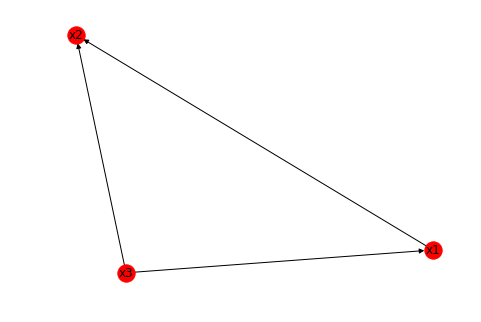

Advantages of possible edge switches: {('x1', 'x2'): 1, ('x3', 'x1'): 0}
Best reversal ('x1', 'x2')


KeyError: ('x1', '0')

In [15]:
## Probability table of initial graph, create initial graph
node_attr_list = [
    ("x3",{
        "state_space":("0","1"),
        "dist":[.8,.2]}),
    ("x1",{ 
        "state_space":("0","1"),
        "dist":{
            (("x3","0")):[.6,.4],
            (("x3","1")):[.4,.6]
        }}),
    ("x2",{
        "state_space":("0","1"),
        "dist":{
            (("x1","0"),("x3","0")):[.4,.1],
            (("x1","1"),("x3","0")):[.3,.2],
            (("x1","0"),("x3","1")):[.4,.1],
            (("x1","1"),("x3","1")):[.25,.25]
        }}),
    ]
edge_list = [("x1","x2"),("x3","x1"),("x3","x2")]

G = nx.DiGraph()
G.clear()
G.add_edges_from(edge_list)
G.add_nodes_from(node_attr_list)
nx.draw(G, with_labels=True)
plt.show()

## Specific to the query - find the best reversal and switch it
target = "x2"
conditions = []

## This sometimes gives me TypeError, 'tuple' object not callable. Don't know why, but restarting the kernel fixes it. 
best_reversal = best_reversal(G,target,conditions)
print("Best reversal", best_reversal)

G_switched = switch_edge_probs(G,best_reversal[0],best_reversal[1], node_attr_list)
nx.draw(G_switched, with_labels=True)
plt.show()

#Print all vertex distributions
for k,v in G_switched.nodes(data=True):
    print(k,v['dist'])

## Example 3

In [ ]:
## Probability table of initial graph, create initial graph
node_attr_list = [
    ("x",{
        "state_space":("0","1"),
        "dist":[.8,.2]}),
    ("y",{ 
        "state_space":("0","1"),
        "dist":{(("x","1")):[.6,.4],
        (("x","0")):[.4,.6]}}),
    ("w",{
        "state_space":("0","1"),
        "dist":{(("y","1")):[.7,.3],
        (("y","0")):[.6,.4]}}),
    ("u",{
        "state_space":("0","1"),
        "dist":{(("y","1")):[.6,.4],
        (("y","0")):[.2,.8]}}),
    ("z",{
        "state_space":("0","1"),
        "dist":{(("w","1")):[.7,.3],
        (("w","0")):[.3,.7]}})
    ]
edge_list = [("x1","x2"),("x3","x1"),("x3","x2")]

G = nx.DiGraph()
G.clear()
G.add_edges_from(edge_list)
G.add_nodes_from(node_attr_list)
nx.draw(G, with_labels=True)
plt.show()


## Specific to the query - find the best reversal and switch it
target = "y"
conditions = "z"

## This sometimes gives me TypeError, 'tuple' object not callable. Don't know why, but restarting the kernel fixes it. 
best_reversal = best_reversal(G,target,conditions)
print("Best reversal", best_reversal)

G_switched = switch_edge_probs(G,best_reversal[0],best_reversal[1], node_attr_list)
nx.draw(G_switched, with_labels=True)
plt.show()

#Print all vertex distributions
for k,v in G_switched.nodes(data=True):
    print(k,v['dist'])
